In [184]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.metrics import recall_score, mean_squared_error, make_scorer, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, learning_curve

import os

# Credit Approval Data Set
[Data Source](https://archive.ics.uci.edu/ml/datasets/Credit+Approval)

In [28]:
def download_credit_ds():
    if not os.path.exists("data"):
        os.makedirs("data")    

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError

    with open("data/credit-approval.csv", 'wb') as file:
        for chunk in response:
            file.write(chunk)

In [29]:
#if you have not data locally, use this
#download_credit_ds()

credit = pd.read_csv("data/credit-approval.csv", header=None, na_values=['?'])
credit.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [30]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       678 non-null    object 
 1   1       678 non-null    float64
 2   2       690 non-null    float64
 3   3       684 non-null    object 
 4   4       684 non-null    object 
 5   5       681 non-null    object 
 6   6       681 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    object 
 13  13      677 non-null    float64
 14  14      690 non-null    int64  
 15  15      690 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB


In [31]:
bool_mask_tf = { 't' : True, 'f' : False }
bool_mask_pm = { '+' : True, '-' : False }

credit[8] = credit[8].map(bool_mask_tf).astype('bool')
credit[9] = credit[9].map(bool_mask_tf).astype('bool')
credit[11] = credit[11].map(bool_mask_tf).astype('bool')
credit[15] = credit[15].map(bool_mask_pm).astype('bool')

In [32]:
print(credit[0].unique())
print(credit[3].unique())
print(credit[4].unique())
print(credit[5].unique())
print(credit[6].unique())
print(credit[12].unique())

['b' 'a' nan]
['u' 'y' nan 'l']
['g' 'p' nan 'gg']
['w' 'q' 'm' 'r' 'cc' 'k' 'c' 'd' 'x' 'i' 'e' 'aa' 'ff' 'j' nan]
['v' 'h' 'bb' 'ff' 'j' 'z' nan 'o' 'dd' 'n']
['g' 's' 'p']


In [33]:
credit[0] = credit[0].astype('category')
credit[3] = credit[3].astype('category')
credit[4] = credit[4].astype('category')
credit[5] = credit[5].astype('category')
credit[6] = credit[6].astype('category')
credit[12] = credit[12].astype('category')

In [34]:
#amount of raws with na
print(credit.isna().sum())
print(f"Sum : {credit.isna().any(axis=1).sum()}")

0     12
1     12
2      0
3      6
4      6
5      9
6      9
7      0
8      0
9      0
10     0
11     0
12     0
13    13
14     0
15     0
dtype: int64
Sum : 37


In [35]:
credit[13].fillna(credit[13].mean(), inplace=True)

for i in [0, 1, 3, 4, 5, 6]:
    credit[i].fillna(credit[i].mode()[0], inplace=True)

In [36]:
def norm_normalize(data):    
    return data / np.linalg.norm(data, axis=0)

def min_max_normalize(data):    
    shift = data - data.min()
    return np.divide(shift, data.max() - data.min())

def mean_normalize(data):
    shift = data - data.mean()
    return np.divide(shift, data.max() - data.min())

def standardize(data):
    shift = data - data.mean()
    return np.divide(shift, data.std())

In [37]:
norm_normalize(credit.select_dtypes(include=[float, int])).describe()

,1,2,7,10,13,14
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.035600,0.026316,0.021078,0.016858,0.027809,0.007301
std,0.013498,0.027529,0.031725,0.034158,0.026017,0.037390
min,0.015582,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025691,0.005530,0.001564,0.000000,0.012090,0.000000
50%,0.031924,0.015207,0.009480,0.000000,0.024180,0.000036
75%,0.042733,0.039857,0.024885,0.021072,0.041106,0.002838
max,0.090945,0.154840,0.270179,0.470619,0.302249,0.717640


In [38]:
min_max_normalize(credit.select_dtypes(include=[float, int]))

,1,2,7,10,13,14
0,0.256842,0.000000,0.043860,0.014925,0.1010,0.00000
1,0.675489,0.159286,0.106667,0.089552,0.0215,0.00560
2,0.161654,0.017857,0.052632,0.000000,0.1400,0.00824
3,0.211729,0.055000,0.131579,0.074627,0.0500,0.00003
4,0.096541,0.200893,0.060000,0.000000,0.0600,0.00000
...,...,...,...,...,...,...
685,0.110226,0.360179,0.043860,0.000000,0.1300,0.00000
686,0.134135,0.026786,0.070175,0.029851,0.1000,0.00394
687,0.172932,0.482143,0.070175,0.014925,0.1000,0.00001
688,0.062707,0.007321,0.001404,0.000000,0.1400,0.00750


In [39]:
mean_normalize(credit.select_dtypes(include=[float, int]))

,1,2,7,10,13,14
0,-0.008773,-0.169954,-0.034155,-0.020896,0.008993,-0.010174
1,0.409873,-0.010669,0.028652,0.053731,-0.070507,-0.004574
2,-0.103961,-0.152097,-0.025383,-0.035821,0.047993,-0.001934
3,-0.053886,-0.114954,0.053565,0.038806,-0.042007,-0.010144
4,-0.169074,0.030938,-0.018014,-0.035821,-0.032007,-0.010174
...,...,...,...,...,...,...
685,-0.155390,0.190224,-0.034155,-0.035821,0.037993,-0.010174
686,-0.131480,-0.143169,-0.007839,-0.005970,0.007993,-0.006234
687,-0.092683,0.312188,-0.007839,-0.020896,0.007993,-0.010164
688,-0.202909,-0.162633,-0.076611,-0.035821,0.047993,-0.002674


In [40]:
standardize(credit.select_dtypes(include=[float, int]))

,1,2,7,10,13,14
0,-0.048985,-0.955920,-0.290872,-0.287892,0.104469,-0.195272
1,2.288489,-0.060007,0.244013,0.740293,-0.819095,-0.087788
2,-0.580458,-0.855481,-0.216167,-0.493529,0.557537,-0.037117
3,-0.300868,-0.646569,0.456175,0.534656,-0.488006,-0.194696
4,-0.944009,0.174015,-0.153415,-0.493529,-0.371835,-0.195272
...,...,...,...,...,...,...
685,-0.867604,1.069928,-0.290872,-0.493529,0.441366,-0.195272
686,-0.734106,-0.805262,-0.066758,-0.082255,0.092851,-0.119649
687,-0.517487,1.755924,-0.066758,-0.287892,0.092851,-0.195080
688,-1.132921,-0.914740,-0.652442,-0.493529,0.557537,-0.051321


In [41]:
def one_hot_encoding(data):
    labels = np.unique(data)
    result = np.zeros((data.size, labels.size))
    for i in range(labels.size):
        result[data == labels[i], i] = 1
    return result

In [42]:
categories = credit.select_dtypes("category")
credit_one_hot = pd.DataFrame()
for i in range(categories.shape[1]):
    uniq_values = np.unique(categories.iloc[:,i])
    names = [str(categories.columns[i]) + str(value) for value in uniq_values]
    temp = pd.DataFrame(one_hot_encoding(categories.iloc[:,i]), columns=names)
    credit_one_hot = pd.concat([credit_one_hot, temp], axis=1)


num_features = credit.select_dtypes(exclude="category")
credit_one_hot = pd.concat([num_features, credit_one_hot], axis=1)

In [43]:
credit_ds = min_max_normalize(credit_one_hot.drop(15, axis=1))
credit_ds

,1,2,7,8,9,10,11,13,14,0a,...,6ff,6h,6j,6n,6o,6v,6z,12g,12p,12s
0,0.256842,0.000000,0.043860,1.0,1.0,0.014925,0.0,0.1010,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.675489,0.159286,0.106667,1.0,1.0,0.089552,0.0,0.0215,0.00560,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.161654,0.017857,0.052632,1.0,0.0,0.000000,0.0,0.1400,0.00824,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.211729,0.055000,0.131579,1.0,1.0,0.074627,1.0,0.0500,0.00003,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.096541,0.200893,0.060000,1.0,0.0,0.000000,0.0,0.0600,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.110226,0.360179,0.043860,0.0,0.0,0.000000,0.0,0.1300,0.00000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
686,0.134135,0.026786,0.070175,0.0,1.0,0.029851,1.0,0.1000,0.00394,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
687,0.172932,0.482143,0.070175,0.0,1.0,0.014925,1.0,0.1000,0.00001,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
688,0.062707,0.007321,0.001404,0.0,0.0,0.000000,0.0,0.1400,0.00750,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [150]:
y =  credit[15].astype("int")
trainX, testX,  trainY, testY = train_test_split(credit_ds, y, test_size=0.5)

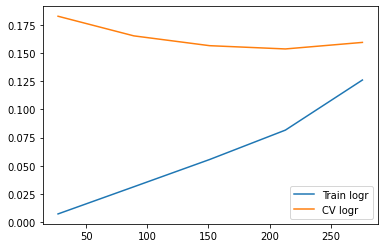

In [159]:
logr = LogisticRegression()
logr.fit(trainX, trainY)

train_size, train_scores, valid_scores = learning_curve(logr, trainX, trainY, scoring=make_scorer(mean_squared_error))

sns.lineplot(train_size, train_scores.mean(axis=1), label="Train logr")
sns.lineplot(train_size, valid_scores.mean(axis=1), label="CV logr")

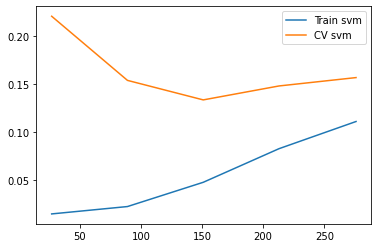

In [157]:
svm = SVC()
svm.fit(trainX, trainY)

train_size, train_scores, valid_scores = learning_curve(svm, trainX, trainY, scoring=make_scorer(mean_squared_error))

sns.lineplot(train_size, train_scores.mean(axis=1), label="Train svm")
sns.lineplot(train_size, valid_scores.mean(axis=1), label="CV svm")

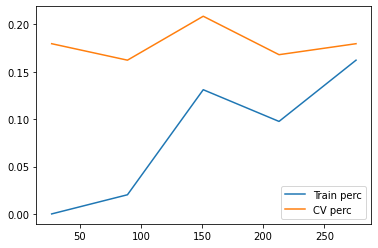

In [165]:
perc = Perceptron()
perc.fit(trainX, trainY)

train_size, train_scores, valid_scores = learning_curve(perc, trainX, trainY, scoring=make_scorer(mean_squared_error))

sns.lineplot(train_size, train_scores.mean(axis=1), label="Train perc")
sns.lineplot(train_size, valid_scores.mean(axis=1), label="CV perc")

In [166]:
print(f"Logistic regession MSE: {mean_squared_error(logr.predict(testX), testY)}")
print(f"Logistic regession MSE: {mean_squared_error(svm.predict(testX), testY)}")
print(f"Logistic regession MSE: {mean_squared_error(perc.predict(testX), testY)}")

Logistic regession MSE: 0.13623188405797101
Logistic regession MSE: 0.14492753623188406
Logistic regession MSE: 0.17101449275362318


In [179]:
print(f"Logistic regession Recall: {recall_score(logr.predict(testX), testY)}")
print(f"Logistic regession Recall: {recall_score(svm.predict(testX), testY)}")
print(f"Logistic regession Recall: {recall_score(perc.predict(testX), testY)}")

Logistic regession Recall: 0.8395061728395061
Logistic regession Recall: 0.8128654970760234
Logistic regession Recall: 0.8181818181818182


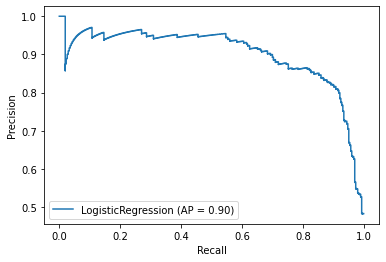

In [185]:
plot_precision_recall_curve(logr, credit_ds, y)